# Particle marginal Metropolis-Hastings (PMMH)

Notebook about testing PMMH.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [2]:
from src.models.lgm import LGModelParams, LGModel
from src.models.mssv import MSSVModelParams, MSSVModel
from src.filters.kalman.kalman_filter import KalmanFilter
from src.filters.pmcmc.pmmh import ParticleMarginalMetropolisHastings
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.auxiliary_pf import AuxiliaryParticleFilter
from src.filters.smc.resampling import systematic_resampling
from src.data_generation.simulate_data import simulate_data

## PMMH testing on LGModel

First we test PMMH on the linear Gaussian model, where we can compute the true posterior using Kalman smoothing.

In [3]:
# Set random seed for reproducibility
rng = np.random.default_rng(123)

# True parameters
true_theta = LGModelParams(
    a=0.7,
    b=1.0,
    sigma_x=0.6,
    sigma_y=0.8
)

# Initialize model
model = LGModel(rng=rng)

In [4]:
T = 100

x_true, y = simulate_data(model, true_theta, T, rng)

In [5]:
x_true = [x.x_t for x in x_true]  # Extract state values from State objects
x_true = np.array(x_true)
print(x_true.shape)
print(y.shape)

(100, 1)
(100, 1)


In [6]:
# Just checking the true log marginal likelihood for the true parameters from the Kalman filter
kf = KalmanFilter()
logmarlik_kf = kf.log_marginal_likelihood(y, true_theta)
mu_smooth, var_smooth = kf.smoother(y, true_theta)
print(f"Kalman filter log marginal likelihood: {logmarlik_kf}")
print(f"Kalman filter marginal likelihood: {np.exp(logmarlik_kf)}")

Kalman filter log marginal likelihood: -146.4524462884645
Kalman filter marginal likelihood: 2.4917858522770288e-64


First, we will use Bootstrap Particle Filter (BPF) as the underlying particle filter in PMMH. We will set the number of particles to $N = 1000$. We could increase this number to ensure even better approximation of the likelihood, but as we will see, even with $N = 1000$ particles, the variance of the likelihood estimates is sufficiently low to allow for good convergence of PMMH.

In [7]:
N = 1000

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)

In [8]:
# Test log marginal likelihood mean and variance for fixed parameters
logmarliks_bpf = []
for _ in range(1000): 
    history = bpf.run(y, true_theta)
    logmarlik = history[-1][3]
    logmarliks_bpf.append(logmarlik)

print(f"BPF log marginal likelihood")
print(f"mean: {np.mean(logmarliks_bpf)}")
print(f"variance: {np.var(logmarliks_bpf)}")

print(f"\nBPF marginal likelihood")
print(f"mean: {np.mean(np.exp(logmarliks_bpf))}")
print(f"variance: {np.var(np.exp(logmarliks_bpf))}")

BPF log marginal likelihood
mean: -146.33043731946415
variance: 0.07356785010870567

BPF marginal likelihood
mean: 2.9195404704105704e-64
variance: 6.342728330806173e-129


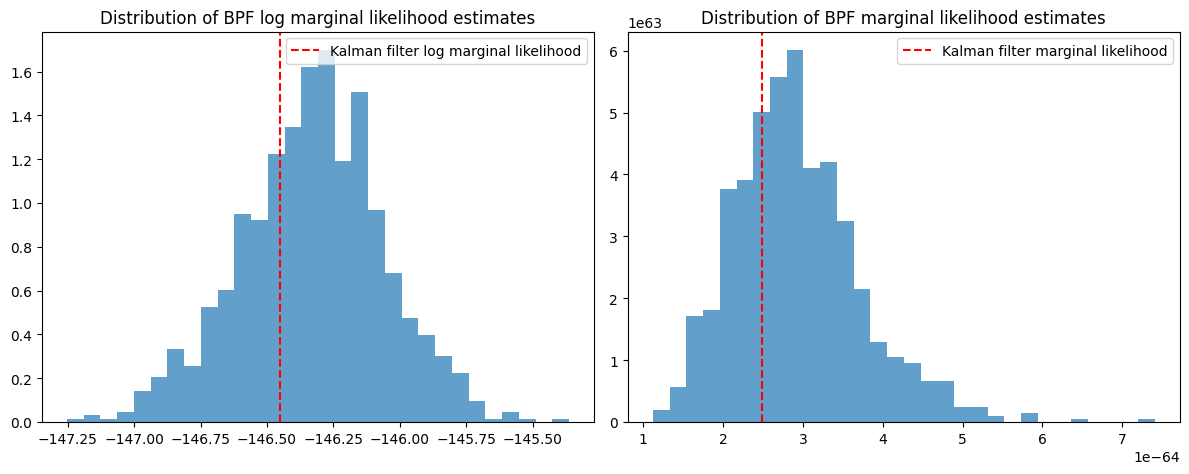

In [9]:
# Plot distribution of marginal likelihood estimates
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(logmarliks_bpf, bins=30, density=True, alpha=0.7)
plt.axvline(logmarlik_kf, color='red', linestyle='--', label='Kalman filter log marginal likelihood')
plt.title("Distribution of BPF log marginal likelihood estimates")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(np.exp(logmarliks_bpf), bins=30, density=True, alpha=0.7)
plt.axvline(np.exp(logmarlik_kf), color='red', linestyle='--', label='Kalman filter marginal likelihood')
plt.title("Distribution of BPF marginal likelihood estimates")
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
kwargs_for_sampling = {
    "step_a": 0.05,
    "step_b": 0.15,
    "step_sigma_x": 0.2,
    "step_sigma_y": 0.2,
}
    
pmmh = ParticleMarginalMetropolisHastings(bpf, kwargs_for_sampling=kwargs_for_sampling)

In [11]:
n_chains = 8
results_bpf = pmmh.run(y, n_iter=10000, n_chain=n_chains, burnin=0)

Chain 1 acceptance rate: 0.165
Chain 2 acceptance rate: 0.316
Chain 3 acceptance rate: 0.338
Chain 4 acceptance rate: 0.338
Chain 5 acceptance rate: 0.342
Chain 6 acceptance rate: 0.322
Chain 7 acceptance rate: 0.340
Chain 8 acceptance rate: 0.338


In [12]:
burn_in = 3000

In [13]:
# Print initial parameters theta for each chain
for chain in range(n_chains):
    _, _, thetas, _ = results_bpf[chain]
    initial_theta = {key: values[0] for key, values in thetas.items()}
    print(f"Chain {chain+1} initial theta: {initial_theta}")

Chain 1 initial theta: {'a': -0.9889027087042881, 'b': 0.8245673409217816, 'sigma_x': 1.7641382167101987, 'sigma_y': 0.15592372402610755}
Chain 2 initial theta: {'a': 0.7601098874256116, 'b': -1.024813858271036, 'sigma_x': 1.0110897173240208, 'sigma_y': 0.0027767491673748664}
Chain 3 initial theta: {'a': 0.146507271644011, 'b': -0.8525886795240178, 'sigma_x': 0.07979905380643573, 'sigma_y': 0.033611131911856516}
Chain 4 initial theta: {'a': 0.28760818178136804, 'b': 1.2978533495957867, 'sigma_x': 1.3754852919197424, 'sigma_y': 2.2297464603804196}
Chain 5 initial theta: {'a': 0.13704515927708272, 'b': 0.9761364417195887, 'sigma_x': 0.12209199411532187, 'sigma_y': 0.7631438597092836}
Chain 6 initial theta: {'a': 0.7165160998247497, 'b': -1.1383748574002384, 'sigma_x': 0.2987812623130615, 'sigma_y': 0.013569643046891807}
Chain 7 initial theta: {'a': 0.0685661923883103, 'b': 1.133537274961927, 'sigma_x': 1.4260927035869468, 'sigma_y': 1.2744018162952924}
Chain 8 initial theta: {'a': 0.3135

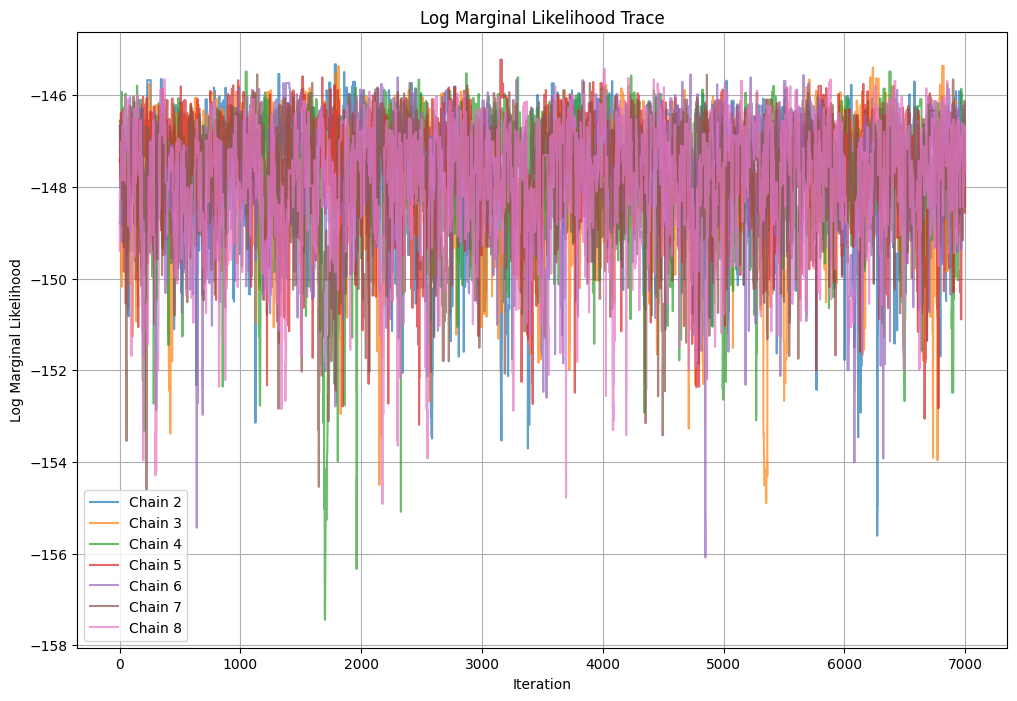

In [22]:
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    samples, logmarliks, thetas, alphas = results_bpf[chain]
    plt.plot(logmarliks[burn_in:], label=f"Chain {chain+1}", alpha=0.7)
    
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Likelihood")
plt.title("Log Marginal Likelihood Trace")
plt.legend()
plt.grid()
plt.show()

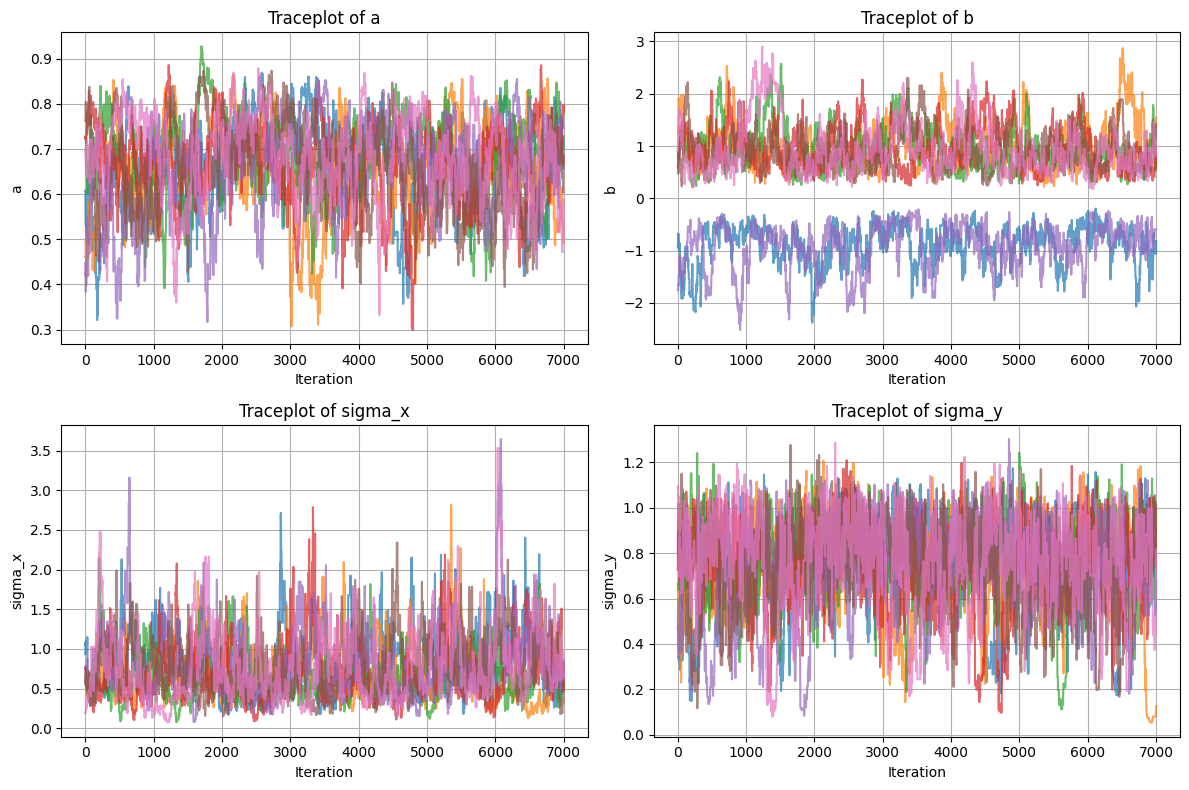

In [15]:
# Traceplot of parameters
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    _, _, thetas, _ = results_bpf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    for i, key in enumerate(thetas_post_burnin.keys()):
        plt.subplot(2, 2, i+1)
        plt.plot(thetas_post_burnin[key], label=f"Chain {chain+1}", alpha=0.7)
        plt.title(f'Traceplot of {key}')
        plt.xlabel('Iteration')
        plt.ylabel(key)
        plt.grid()
plt.tight_layout()
plt.show()

In [16]:
# Print summary statistics for parameters
results_bpf_converged = [result for i, result in enumerate(results_bpf) if i != 0]  # Exclude the 1st chain which seems to have diverged

idata = pmmh.to_inference_data(results_bpf_converged)
display(az.summary(idata))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
logmarliks,-155.001,454.414,-150.407,-145.799,6.545,208.716,1717.0,2386.0,1.00
a,0.669,0.101,0.490,0.849,0.005,0.003,349.0,766.0,1.02
b,0.398,0.967,-1.503,1.913,0.327,0.146,12.0,68.0,1.57
sigma_x,0.738,0.378,0.153,1.410,0.016,0.013,532.0,1044.0,1.01
sigma_y,0.737,0.215,0.281,1.077,0.013,0.015,354.0,202.0,1.02


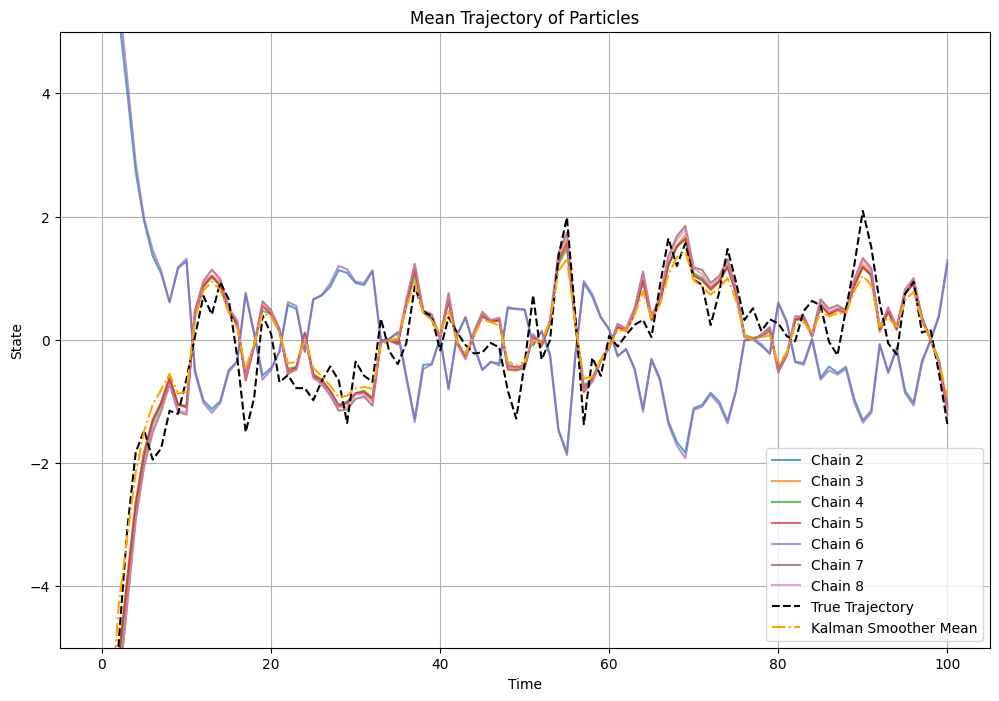

In [20]:
# Now let's look at samples of trajectories
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    samples, _, _, _ = results_bpf[chain]
    # Compute mean trajectory post burn-in
    samples_x = np.array([sample.x_t for sample in samples])    # shapre (T+1, N)
    mean_trajectory = np.mean(samples_x, axis=1)
    plt.plot(mean_trajectory, label=f"Chain {chain+1}", alpha=0.7)
plt.plot(np.arange(1, len(x_true)+1), x_true, label="True Trajectory", color='black', linestyle='--')
plt.plot(np.arange(1, len(mu_smooth)+1), mu_smooth, label="Kalman Smoother Mean", color='orange', linestyle='-.')
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Mean Trajectory of Particles")
plt.legend()
plt.grid()
plt.ylim(-5, 5)
plt.show()

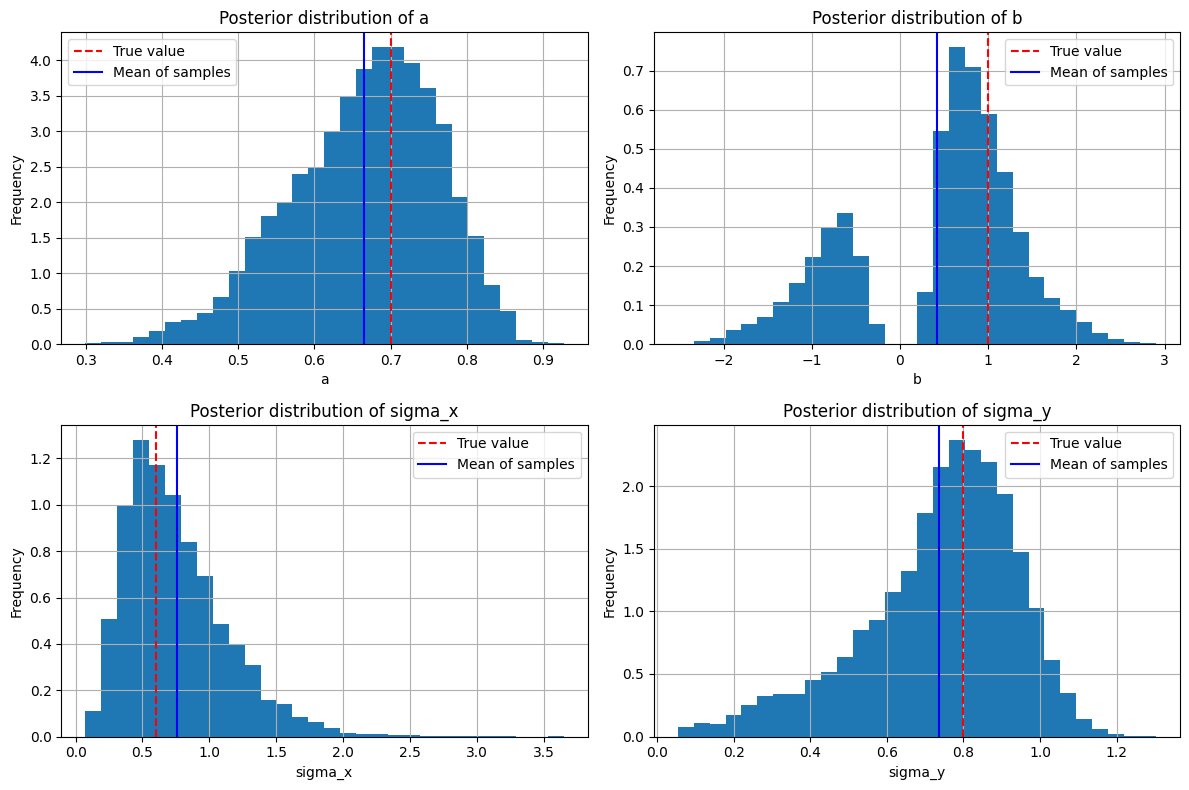

In [23]:
# Plot distribution of parameters post burn-in
chain_thetas = []
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    _, _, thetas, _ = results_bpf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    chain_thetas.append(thetas_post_burnin)
for key in chain_thetas[0].keys():
    plt.subplot(2, 2, list(chain_thetas[0].keys()).index(key)+1)
    joint_samples = np.concatenate([chain_thetas[chain][key] for chain in range(len(chain_thetas))])
    plt.hist(joint_samples, bins=30, density=True)
    plt.axvline(getattr(true_theta, key), color='red', linestyle='--', label='True value')
    plt.axvline(np.mean(joint_samples), color='blue', linestyle='-', label='Mean of samples')
    plt.title(f"Posterior distribution of {key}")
    plt.xlabel(key)
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

Let's explain why we observe such results. Some chains converge to approximately true parameter values, while others converge to different values. 

Chains differ in parameter $b$ to which they converge. Instead of oscillating around $1$, it oscillates around $-1$. This is the identifiability issue. 
Linear Gaussian state-space model is defined as:
$$
\begin{aligned}
x_t &= a x_{t-1} + \sigma_x \epsilon_t, \qquad \epsilon_t \sim \mathcal{N}(0, 1) \\
y_t &= b x_t + \sigma_y \eta_t, \qquad \eta_t \sim \mathcal{N}(0, 1)
\end{aligned}
$$
Now let's define transformation $\tilde{x}_t = -x_t$ and $\tilde{b} = -b$ and keeping other parameters the same. Now we can show that state equation and observation equation are invariant to this transformation:
$$
\begin{aligned}
\tilde{x}_t &= -x_t = -a x_{t-1} - \sigma_x \epsilon_t = a \tilde{x}_{t-1} + \sigma_x (-\epsilon_t) \\
y_t &= b x_t + \sigma_y \eta_t = \tilde{b} \tilde{x}_t + \sigma_y \eta_t
\end{aligned}
$$
Since $\epsilon_t$ and $-\epsilon_t$ have the same distribution, the likelihood of the data given parameters $(a, b, \sigma_x, \sigma_y)$ is the same as the likelihood given parameters $(a, -b, \sigma_x, \sigma_y)$. This means that the model cannot distinguish between these two sets of parameters based on the observed data alone. This is also reflected in the posterior distribution of latent states $x_t$, where those chains that converge correctly to $b \approx 1$ will have correct posterior distribution of $x_t$, while those that converge to $b \approx -1$ will have exactly the reflected posterior distribution of $\tilde{x}_t = -x_t$.

As a result, the posterior distribution will have two modes corresponding to these parameter sets, leading to identifiability issues.


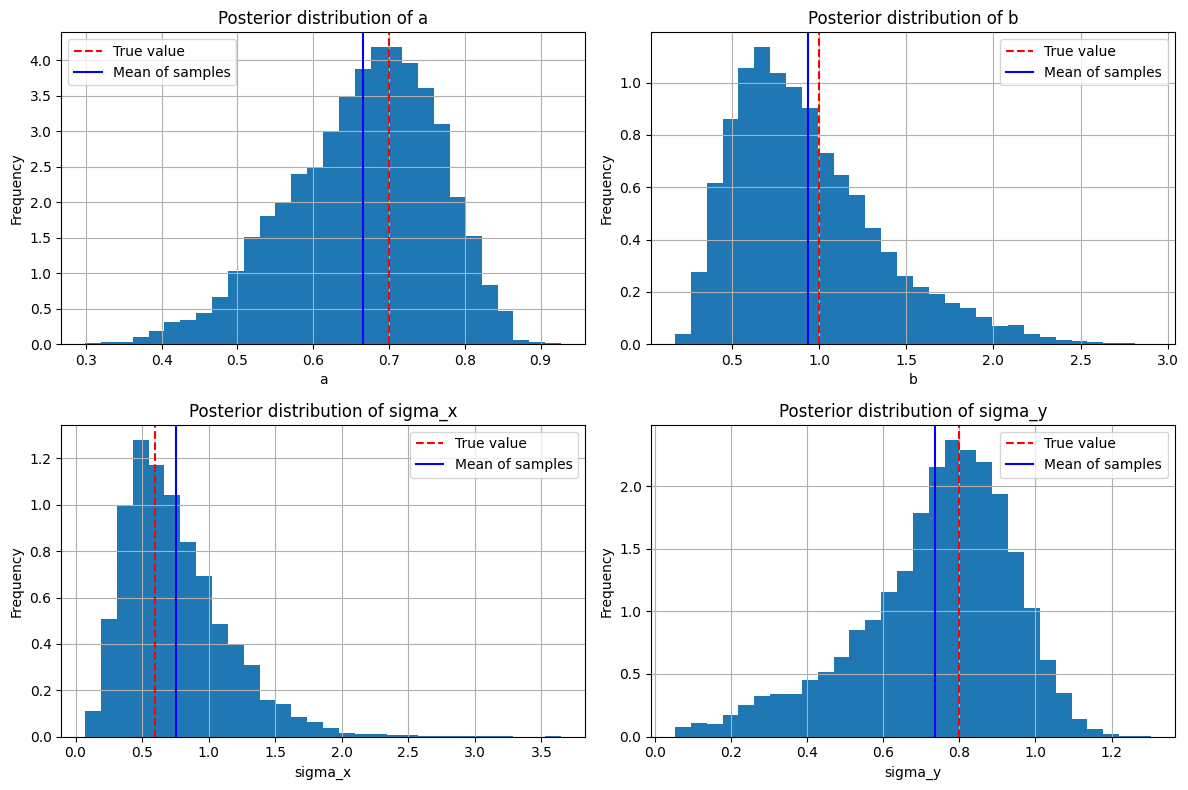

In [24]:
# Plot distribution of parameters post burn-in 
# but now take absolute value for parameter b !!
chain_thetas = []
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    _, _, thetas, _ = results_bpf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    chain_thetas.append(thetas_post_burnin)
for key in chain_thetas[0].keys():
    if key == "b":
        for chain in range(len(chain_thetas)):
            chain_thetas[chain][key] = np.abs(chain_thetas[chain][key])
    plt.subplot(2, 2, list(chain_thetas[0].keys()).index(key)+1)
    joint_samples = np.concatenate([chain_thetas[chain][key] for chain in range(len(chain_thetas))])
    plt.hist(joint_samples, bins=30, density=True)
    plt.axvline(getattr(true_theta, key), color='red', linestyle='--', label='True value')
    plt.axvline(np.mean(joint_samples), color='blue', linestyle='-', label='Mean of samples')
    plt.title(f"Posterior distribution of {key}")
    plt.xlabel(key)
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

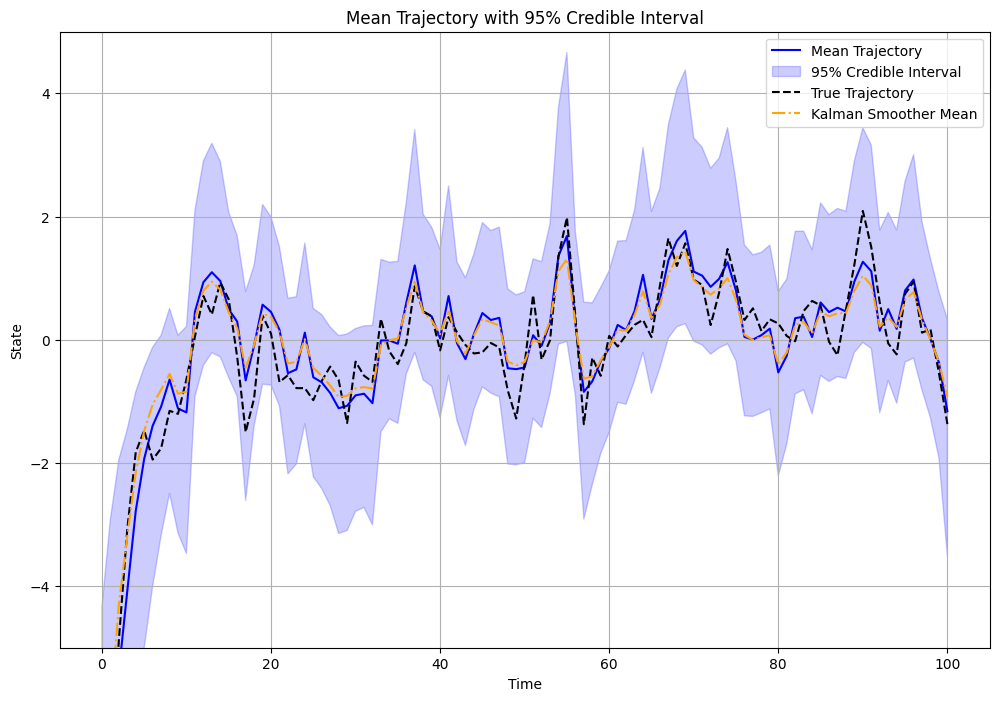

In [52]:
# Plot mean trajectory with credible intervals across all chains
plt.figure(figsize=(12, 8))
all_samples_x = []
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    samples, _, _, _ = results_bpf[chain]
    samples_x = np.array([sample.x_t for sample in samples])    # shapre (T+1, N)
    if chain == 1 or chain == 5:
        # Invert values for chains 2 and 6 to correct the identifiability issue
        samples_x = -samples_x
    all_samples_x.append(samples_x)
all_samples_x = np.concatenate(all_samples_x, axis=1)   # shape (T+1, N * n_chains)
mean_trajectory = np.mean(all_samples_x, axis=1)
lower_bound = np.percentile(all_samples_x, 2.5, axis=1)
upper_bound = np.percentile(all_samples_x, 97.5, axis=1)
plt.plot(mean_trajectory, label="Mean Trajectory", color='blue')
plt.fill_between(np.arange(0, len(mean_trajectory)), lower_bound, upper_bound, color='blue', alpha=0.2, label="95% Credible Interval")
plt.plot(np.arange(1, len(x_true)+1), x_true, label="True Trajectory", color='black', linestyle='--')
plt.plot(np.arange(1, len(mu_smooth)+1), mu_smooth, label="Kalman Smoother Mean", color='orange', linestyle='-.')
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Mean Trajectory with 95% Credible Interval")
plt.legend()
plt.ylim(-5, 5)
plt.grid()

Now let's check if using Auxiliary Particle Filter (APF) instead of Bootstrap Particle Filter (BPF) can improve the convergence of PMMH. We will use the same number of particles $N = 1000$ for both filters to ensure a fair comparison.

In [25]:
apf = AuxiliaryParticleFilter(model, N, resampler=systematic_resampling)

In [26]:
# Test log marginal likelihood mean and variance for fixed parameters
logmarliks_apf = []
for _ in range(1000): 
    history = apf.run(y, true_theta)
    logmarlik = history[-1][3]
    logmarliks_apf.append(logmarlik)

print(f"APF log marginal likelihood")
print(f"mean: {np.mean(logmarliks_apf)}")
print(f"variance: {np.var(logmarliks_apf)}")

print(f"\nAPF marginal likelihood")
print(f"mean: {np.mean(np.exp(logmarliks_apf))}")
print(f"variance: {np.var(np.exp(logmarliks_apf))}")

APF log marginal likelihood
mean: -146.32816140349973
variance: 0.09433952444708567

APF marginal likelihood
mean: 2.957653451280105e-64
variance: 8.645113358339843e-129


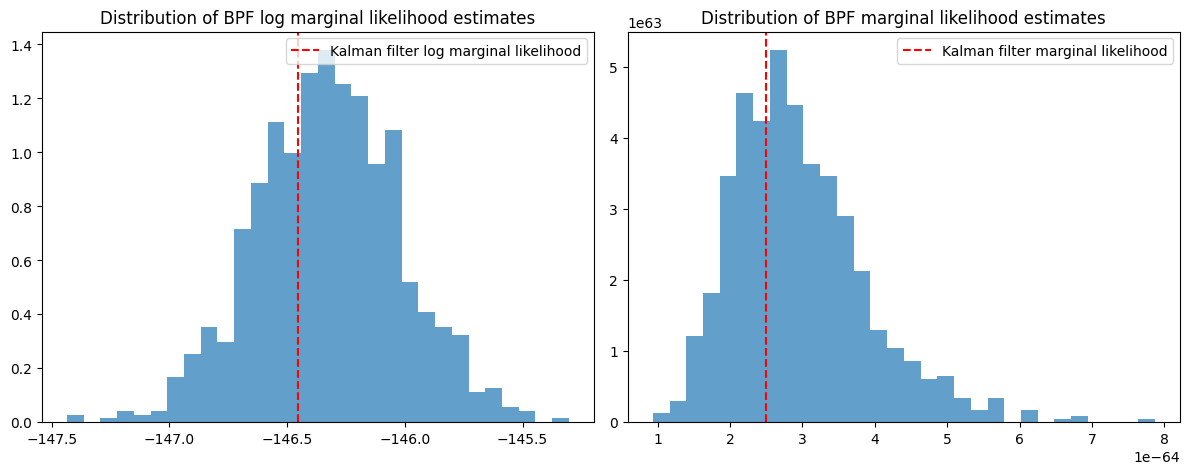

In [27]:
# Plot distribution of marginal likelihood estimates
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(logmarliks_apf, bins=30, density=True, alpha=0.7)
plt.axvline(logmarlik_kf, color='red', linestyle='--', label='Kalman filter log marginal likelihood')
plt.title("Distribution of BPF log marginal likelihood estimates")
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(np.exp(logmarliks_apf), bins=30, density=True, alpha=0.7)
plt.axvline(np.exp(logmarlik_kf), color='red', linestyle='--', label='Kalman filter marginal likelihood')
plt.title("Distribution of BPF marginal likelihood estimates")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
kwargs_for_sampling = {
    "step_a": 0.05,
    "step_b": 0.15,
    "step_sigma_x": 0.2,
    "step_sigma_y": 0.2,
}
    
pmmh = ParticleMarginalMetropolisHastings(apf, kwargs_for_sampling=kwargs_for_sampling)

In [29]:
n_chains = 8
results_apf = pmmh.run(y, n_iter=10000, n_chain=n_chains, burnin=0)

Chain 1 acceptance rate: 0.340
Chain 2 acceptance rate: 0.332
Chain 3 acceptance rate: 0.309
Chain 4 acceptance rate: 0.330
Chain 5 acceptance rate: 0.326
Chain 6 acceptance rate: 0.329
Chain 7 acceptance rate: 0.332
Chain 8 acceptance rate: 0.327


In [30]:
burn_in = 5000

In [31]:
# Print initial parameters theta for each chain
for chain in range(n_chains):
    _, _, thetas, _ = results_apf[chain]
    initial_theta = {key: values[0] for key, values in thetas.items()}
    print(f"Chain {chain+1} initial theta: {initial_theta}")

Chain 1 initial theta: {'a': -0.6852847071777031, 'b': 0.6514187144058844, 'sigma_x': 1.668754436112647, 'sigma_y': 1.0143628886243596}
Chain 2 initial theta: {'a': -0.17787690816604118, 'b': -0.9035827574891665, 'sigma_x': 0.029539337236553363, 'sigma_y': 3.164404733228323}
Chain 3 initial theta: {'a': 0.8043134318552569, 'b': -0.6516894783100049, 'sigma_x': 0.28001019962315377, 'sigma_y': 2.273794929523547}
Chain 4 initial theta: {'a': -0.7683053837721552, 'b': 0.8337726316054102, 'sigma_x': 0.44543802320042575, 'sigma_y': 0.9879379274268396}
Chain 5 initial theta: {'a': -0.8737428397110674, 'b': 0.026469013411785636, 'sigma_x': 0.7926743555304802, 'sigma_y': 0.00452571463033579}
Chain 6 initial theta: {'a': 0.4914195035589286, 'b': -0.8430157983753587, 'sigma_x': 0.4188951368411421, 'sigma_y': 0.8658105643025716}
Chain 7 initial theta: {'a': -0.765535612437654, 'b': -0.319984652982975, 'sigma_x': 3.25014600700518, 'sigma_y': 0.2372049720381773}
Chain 8 initial theta: {'a': -0.482367

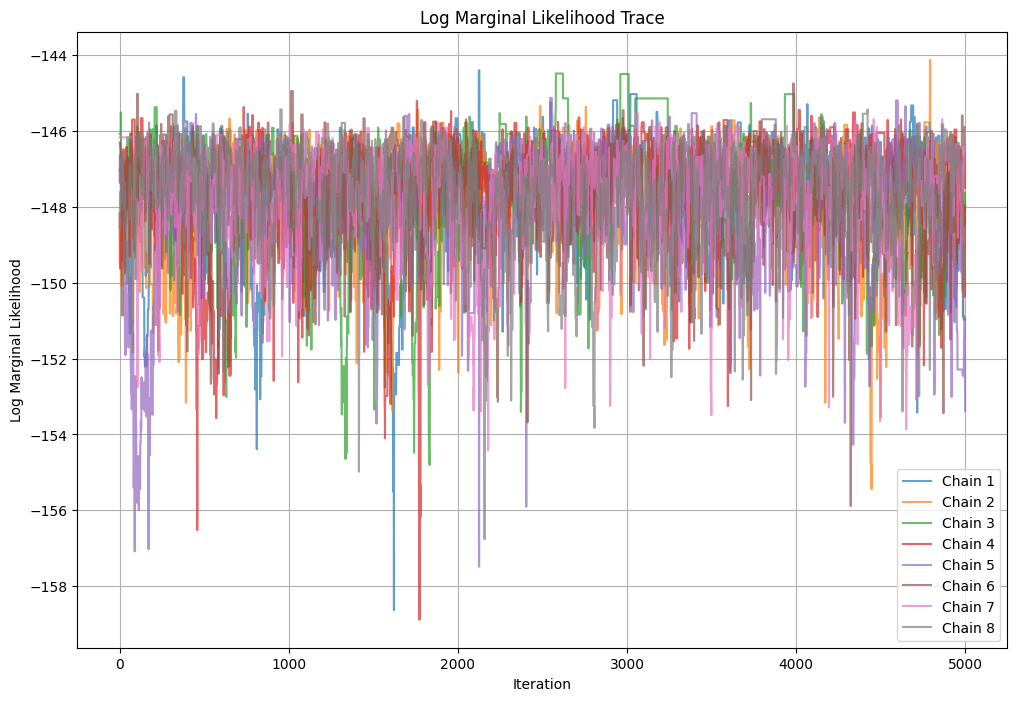

In [32]:
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    samples, logmarliks, thetas, alphas = results_apf[chain]
    plt.plot(logmarliks[burn_in:], label=f"Chain {chain+1}", alpha=0.7)
    
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Likelihood")
plt.title("Log Marginal Likelihood Trace")
plt.legend()
plt.grid()
plt.show()

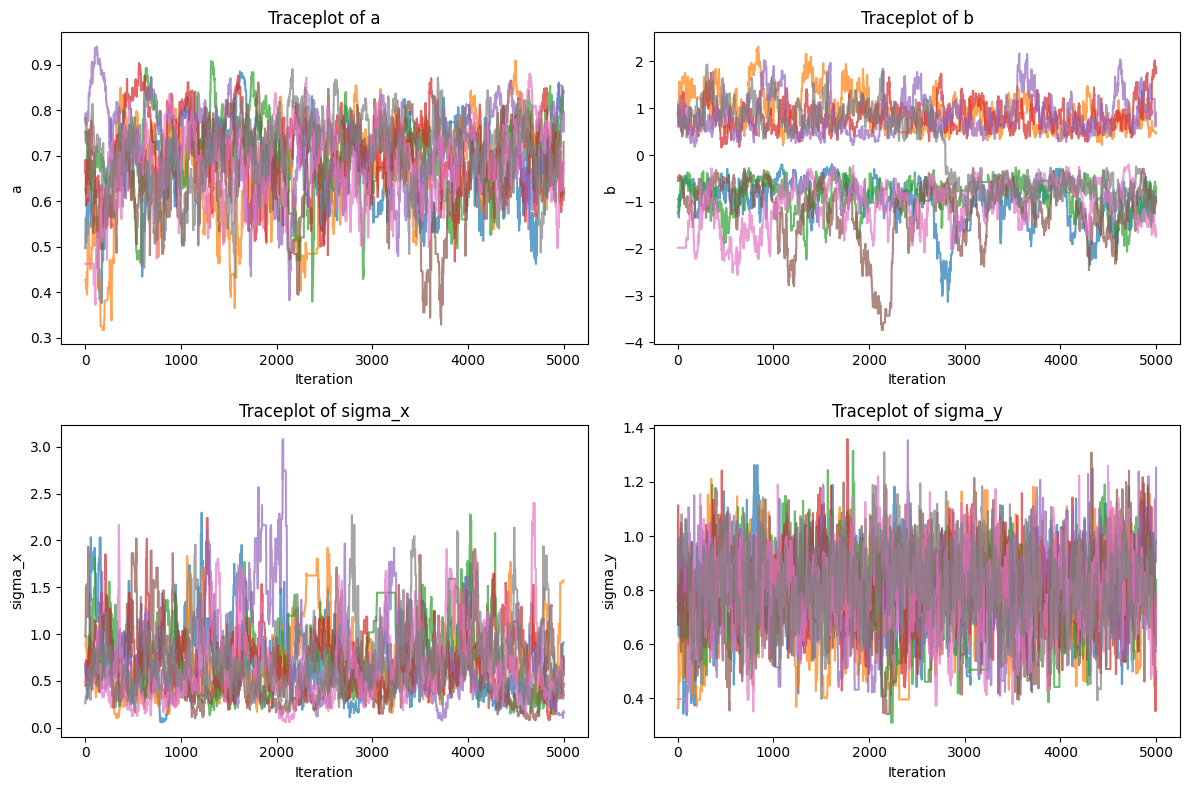

In [33]:
# Traceplot of parameters
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    _, _, thetas, _ = results_apf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    for i, key in enumerate(thetas_post_burnin.keys()):
        plt.subplot(2, 2, i+1)
        plt.plot(thetas_post_burnin[key], label=f"Chain {chain+1}", alpha=0.7)
        plt.title(f'Traceplot of {key}')
        plt.xlabel('Iteration')
        plt.ylabel(key)
        plt.grid()
plt.tight_layout()
plt.show()

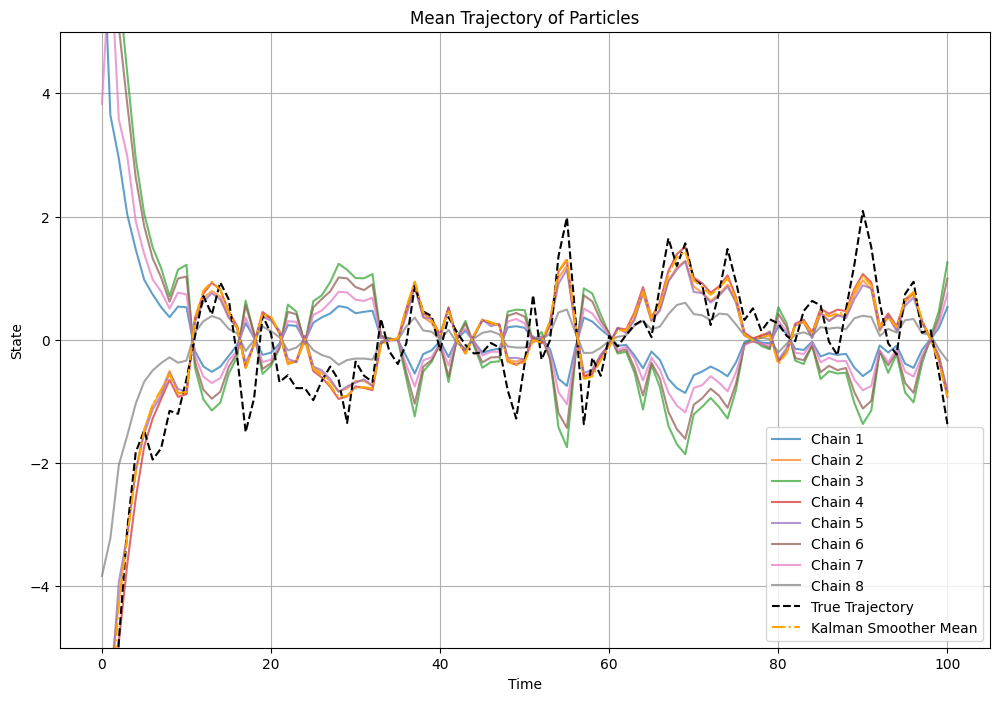

In [44]:
# Now let's look at samples of trajectories
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    samples, _, _, _ = results_apf[chain]
    # Compute mean trajectory post burn-in
    samples_x = np.array([sample.x_t for sample in samples])    # shapre (T+1, N)
    mean_trajectory = np.mean(samples_x, axis=1)
    plt.plot(mean_trajectory, label=f"Chain {chain+1}", alpha=0.7)
plt.plot(np.arange(1, len(x_true)+1), x_true, label="True Trajectory", color='black', linestyle='--')
plt.plot(np.arange(1, len(mu_smooth)+1), mu_smooth, label="Kalman Smoother Mean", color='orange', linestyle='-.')
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Mean Trajectory of Particles")
plt.legend()
plt.grid()
plt.ylim(-5, 5)
plt.show()

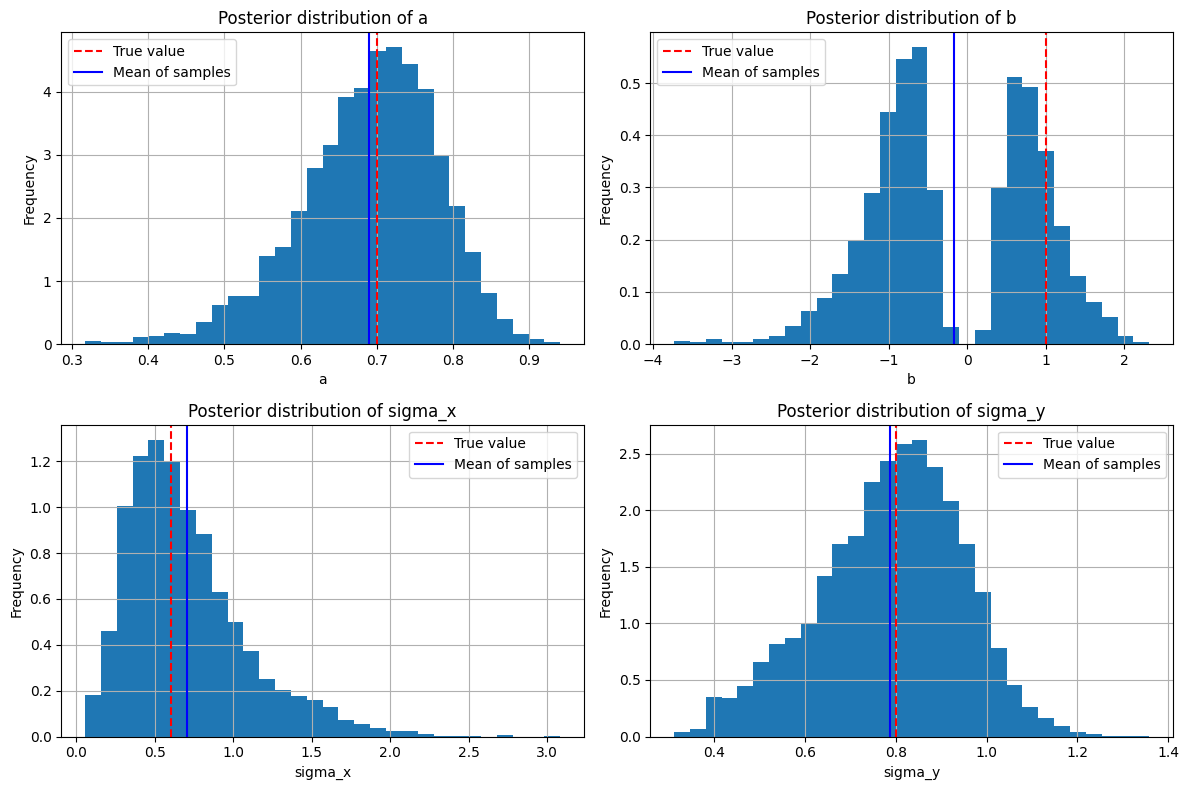

In [35]:
# Plot distribution of parameters post burn-in
chain_thetas = []
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    _, _, thetas, _ = results_apf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    chain_thetas.append(thetas_post_burnin)
for key in chain_thetas[0].keys():
    plt.subplot(2, 2, list(chain_thetas[0].keys()).index(key)+1)
    joint_samples = np.concatenate([chain_thetas[chain][key] for chain in range(len(chain_thetas))])
    plt.hist(joint_samples, bins=30, density=True)
    plt.axvline(getattr(true_theta, key), color='red', linestyle='--', label='True value')
    plt.axvline(np.mean(joint_samples), color='blue', linestyle='-', label='Mean of samples')
    plt.title(f"Posterior distribution of {key}")
    plt.xlabel(key)
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

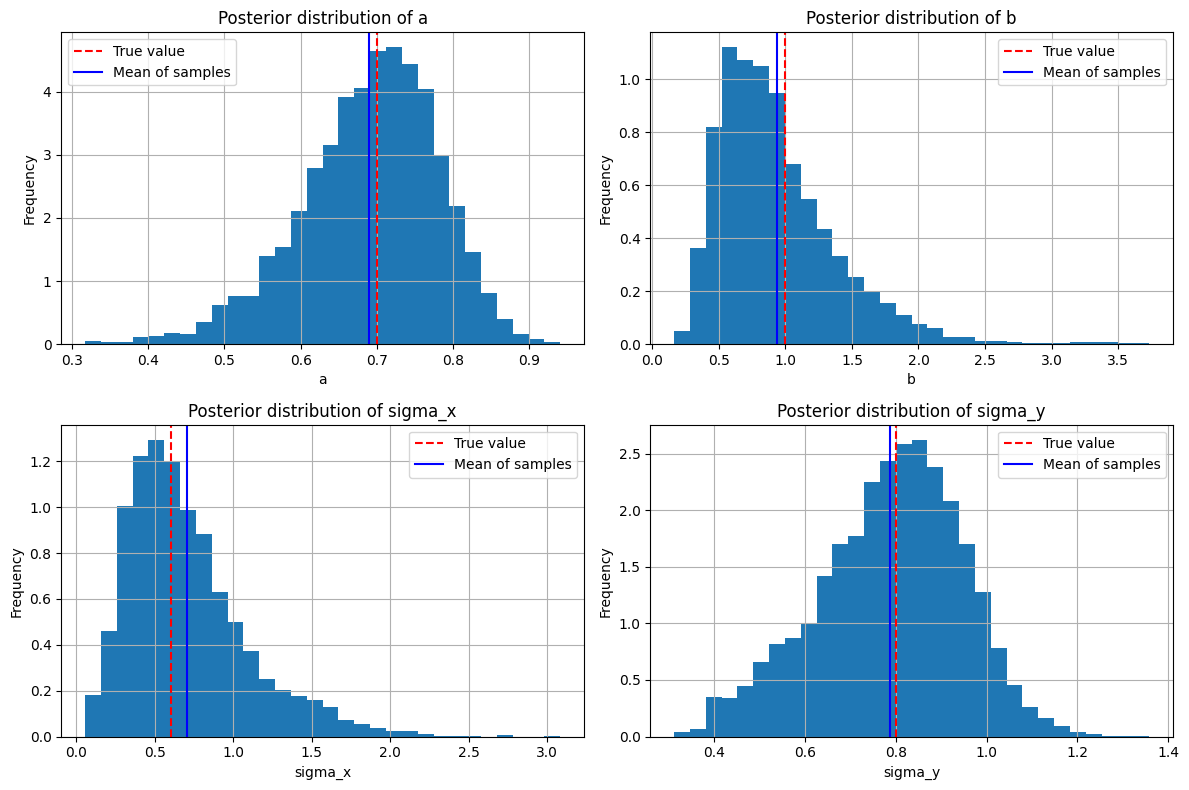

In [36]:
# Again plot distribution of parameters post burn-in but now take absolute value for parameter b !!
chain_thetas = []
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    _, _, thetas, _ = results_apf[chain]
    thetas_post_burnin = {key: values[burn_in:] for key, values in thetas.items()}
    chain_thetas.append(thetas_post_burnin)
for key in chain_thetas[0].keys():
    if key == "b":
        for chain in range(len(chain_thetas)):
            chain_thetas[chain][key] = np.abs(chain_thetas[chain][key])
    plt.subplot(2, 2, list(chain_thetas[0].keys()).index(key)+1)
    joint_samples = np.concatenate([chain_thetas[chain][key] for chain in range(len(chain_thetas))])
    plt.hist(joint_samples, bins=30, density=True)
    plt.axvline(getattr(true_theta, key), color='red', linestyle='--', label='True value')
    plt.axvline(np.mean(joint_samples), color='blue', linestyle='-', label='Mean of samples')
    plt.title(f"Posterior distribution of {key}")
    plt.xlabel(key)
    plt.ylabel("Frequency")
    plt.grid()
    plt.legend()
plt.tight_layout()
plt.show()

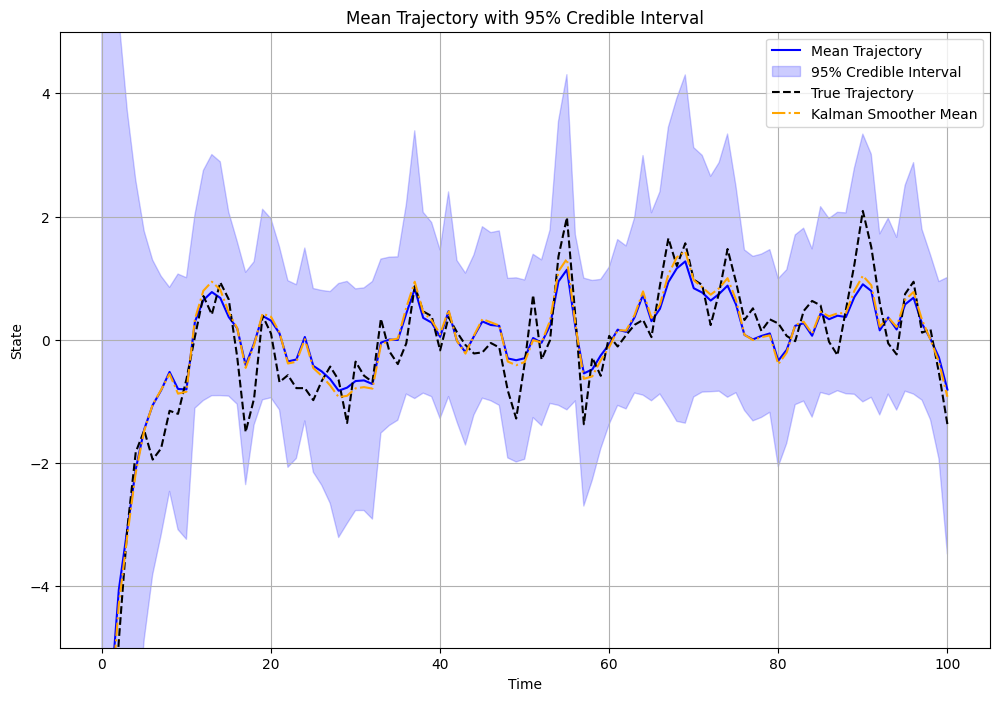

In [55]:
# Plot mean trajectory with credible intervals across all chains
plt.figure(figsize=(12, 8))
all_samples_x = []
for chain in range(n_chains):
    samples, _, _, _ = results_apf[chain]
    samples_x = np.array([sample.x_t for sample in samples])    # shapre (T+1, N)
    if chain in [0, 2, 5, 6]:
        # Invert values for some chains to correct the identifiability issue
        samples_x = -samples_x
    all_samples_x.append(samples_x)
all_samples_x = np.concatenate(all_samples_x, axis=1)   # shape (T+1, N * n_chains)
mean_trajectory = np.mean(all_samples_x, axis=1)
lower_bound = np.percentile(all_samples_x, 2.5, axis=1)
upper_bound = np.percentile(all_samples_x, 97.5, axis=1)
plt.plot(mean_trajectory, label="Mean Trajectory", color='blue')
plt.fill_between(np.arange(0, len(mean_trajectory)), lower_bound, upper_bound, color='blue', alpha=0.2, label="95% Credible Interval")
plt.plot(np.arange(1, len(x_true)+1), x_true, label="True Trajectory", color='black', linestyle='--')
plt.plot(np.arange(1, len(mu_smooth)+1), mu_smooth, label="Kalman Smoother Mean", color='orange', linestyle='-.')
plt.xlabel("Time")
plt.ylabel("State")
plt.title("Mean Trajectory with 95% Credible Interval")
plt.legend()
plt.ylim(-5, 5)
plt.grid()

We see that both BPF and APF give nice estimates of parameters and both give nice estimates of mean of latent states. However, APF gives much wider credible intervals for latent states. Let's more specifically compare mean and variance of latent states from both BPF and APF relative to analytical solution given by Kalman smoother.

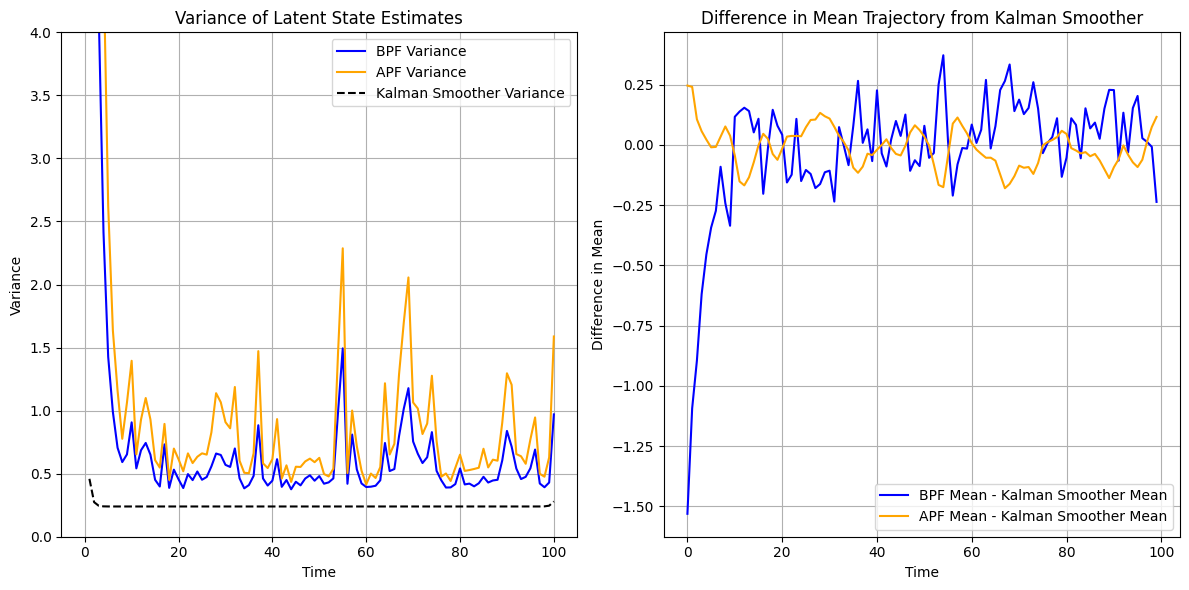

In [71]:
# BPF samples of trajectories
bpf_samples_x = []
for chain in range(n_chains):
    if chain == 0:
        continue       # Skip the 1st chain which seems to have diverged
    samples, _, _, _ = results_bpf[chain]
    samples_x = np.array([sample.x_t for sample in samples])    # shapre (T+1, N)
    if chain in [1, 5]:
        # Invert values for some chains to correct the identifiability issue
        samples_x = -samples_x
    bpf_samples_x.append(samples_x)
bpf_samples_x = np.concatenate(bpf_samples_x, axis=1)   # shape (T+1, N * n_chains)

# APF samples of trajectories
apf_samples_x = []
for chain in range(n_chains):
    samples, _, _, _ = results_apf[chain]
    samples_x = np.array([sample.x_t for sample in samples])    # shapre (T+1, N)
    if chain in [0, 2, 5, 6]:
        # Invert values for some chains to correct the identifiability issue
        samples_x = -samples_x
    apf_samples_x.append(samples_x)
apf_samples_x = np.concatenate(apf_samples_x, axis=1)   # shape (T+1, N * n_chains)

# Plot variances
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
bpf_variance = np.var(bpf_samples_x, axis=1)
plt.plot(bpf_variance, label="BPF Variance", color='blue')
apf_variance = np.var(apf_samples_x, axis=1)
plt.plot(apf_variance, label="APF Variance", color='orange')
plt.plot(np.arange(1, len(var_smooth)+1), var_smooth, label="Kalman Smoother Variance", color='black', linestyle='--')
plt.xlabel("Time")
plt.ylabel("Variance")
plt.title("Variance of Latent State Estimates")
plt.ylim(0,4)
plt.legend()
plt.grid()
plt.subplot(1, 2, 2)
bpf_mean = np.mean(bpf_samples_x, axis=1)
apf_mean = np.mean(apf_samples_x, axis=1)
plt.plot(bpf_mean[1:] - mu_smooth, label="BPF Mean - Kalman Smoother Mean", color='blue')
plt.plot(apf_mean[1:] - mu_smooth, label="APF Mean - Kalman Smoother Mean", color='orange')
plt.xlabel("Time")
plt.ylabel("Difference in Mean")
plt.title("Difference in Mean Trajectory from Kalman Smoother")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## PMMG testing on MSSV model

Now we apply PMMH on the main model of interest, the MSSV model.

In [3]:
# Random seed
rng = np.random.default_rng(123)

# True parameters
true_theta = MSSVModelParams(
    mu=[-1.0, 1.6],
    phi=[0.95, 0.95],
    sigma_eta=[0.1, 0.2],
    P=[[0.95, 0.05],
        [0.05, 0.95]]
)

# Initialize model
model = MSSVModel(rng=rng)

In [4]:
T = 100

x_true, y = simulate_data(model, true_theta, T, rng)

In [5]:
h_true = [x.h_t for x in x_true]
h_true = np.array(h_true)
s_true = [x.s_t for x in x_true]
s_true = np.array(s_true)

print(h_true.shape)
print(s_true.shape)
print(y.shape)

(100, 1)
(100, 1, 2)
(100, 1)


Again we first use BPF as the underlying particle filter in PMMH. We will set the number of particles to $N = 1000$.

In [6]:
N = 1000

bpf = BootstrapParticleFilter(model, N, resampler=systematic_resampling)

In [7]:
# Test log marginal likelihood mean and variance for fixed parameters
logmarliks_bpf = []
for _ in range(1000): 
    history = bpf.run(y, true_theta)
    logmarlik = history[-1][3]
    logmarliks_bpf.append(logmarlik)

print(f"BPF log marginal likelihood")
print(f"mean: {np.mean(logmarliks_bpf)}")
print(f"variance: {np.var(logmarliks_bpf)}")

print(f"\nBPF marginal likelihood")
print(f"mean: {np.mean(np.exp(logmarliks_bpf))}")
print(f"variance: {np.var(np.exp(logmarliks_bpf))}")

BPF log marginal likelihood
mean: -110.44862620281968
variance: 0.03136780863492162

BPF marginal likelihood
mean: 1.0954254412689647e-48
variance: 3.817198454670295e-98


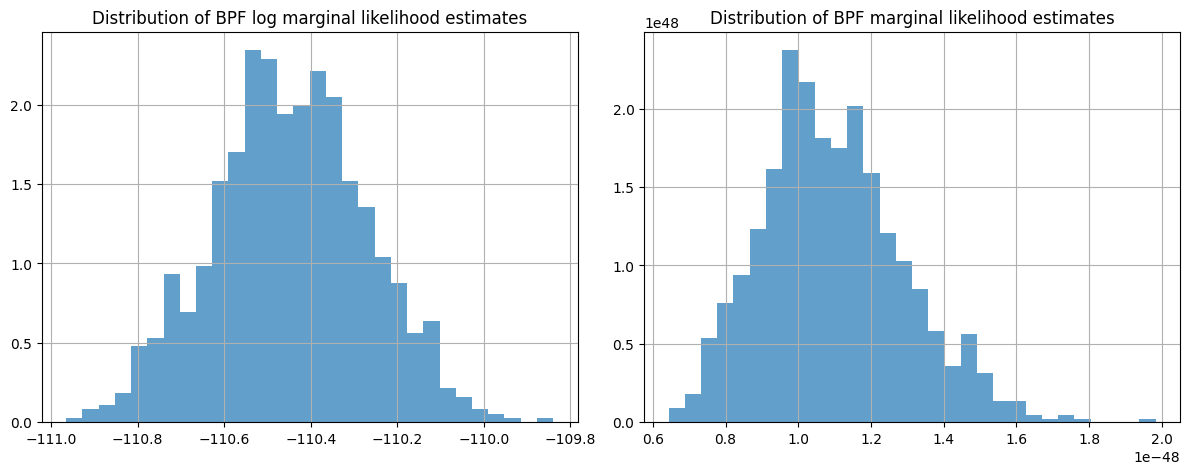

In [8]:
# Plot distribution of marginal likelihood estimates
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(logmarliks_bpf, bins=30, density=True, alpha=0.7)
plt.title("Distribution of BPF log marginal likelihood estimates")
plt.grid()
plt.subplot(1, 2, 2)
plt.hist(np.exp(logmarliks_bpf), bins=30, density=True, alpha=0.7)
plt.title("Distribution of BPF marginal likelihood estimates")
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
kwargs_for_sampling = {
    "step_mu": 0.1,
    "step_phi": 0.05,
    "step_sigma": 0.2,
    "step_P": 10.0
}

K = 2
kwargs_for_params = {
    "num_regimes": K
}

pmmh = ParticleMarginalMetropolisHastings(bpf, kwargs_for_sampling=kwargs_for_sampling, kwargs_for_params=kwargs_for_params)

In [10]:
n_chains = 1
results_bpf = pmmh.run(y, n_iter=10000, n_chain=n_chains, burnin=0)

Chain progress: 1000/10000 iterations completed.
Chain progress: 2000/10000 iterations completed.
Chain progress: 3000/10000 iterations completed.
Chain progress: 4000/10000 iterations completed.
Chain progress: 5000/10000 iterations completed.
Chain progress: 6000/10000 iterations completed.
Chain progress: 7000/10000 iterations completed.
Chain progress: 8000/10000 iterations completed.
Chain progress: 9000/10000 iterations completed.
Chain progress: 10000/10000 iterations completed.
Chain 1 acceptance rate: 0.035


In [15]:
burn_in = 3000

In [16]:
# Print initial parameters theta for each chain
for chain in range(n_chains):
    _, _, thetas, _ = results_bpf[chain]
    initial_theta = {key: values[0] for key, values in thetas.items()}
    print(f"Chain {chain+1} initial theta: {initial_theta}")

Chain 1 initial theta: {'mu': array([-19.95032311,  17.89538285]), 'phi': array([0.9092779 , 0.26822486]), 'sigma_eta': array([1.41605558, 0.6239877 ]), 'P': array([[0.10572912, 0.89427088],
       [0.20310638, 0.79689362]])}


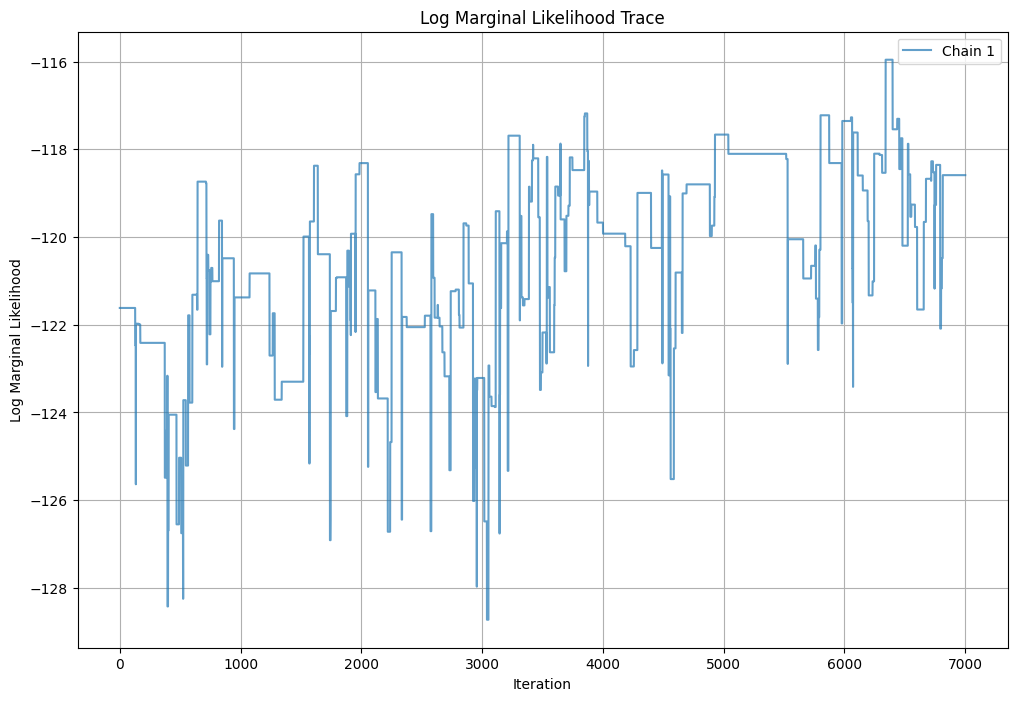

In [17]:
plt.figure(figsize=(12, 8))
for chain in range(n_chains):
    samples, logmarliks, thetas, alphas = results_bpf[chain]
    plt.plot(logmarliks[burn_in:], label=f"Chain {chain+1}", alpha=0.7)
    
plt.xlabel("Iteration")
plt.ylabel("Log Marginal Likelihood")
plt.title("Log Marginal Likelihood Trace")
plt.legend()
plt.grid()
plt.show()

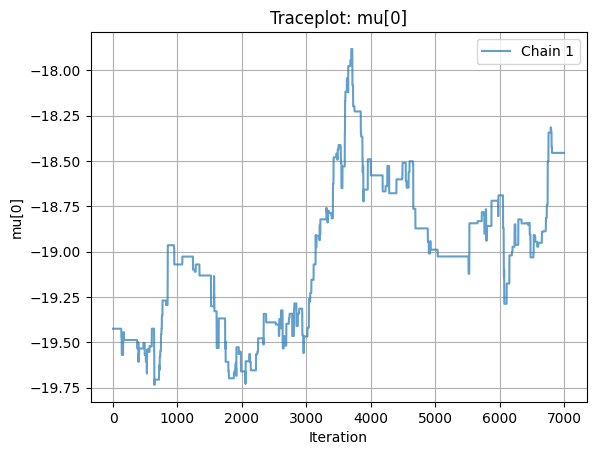

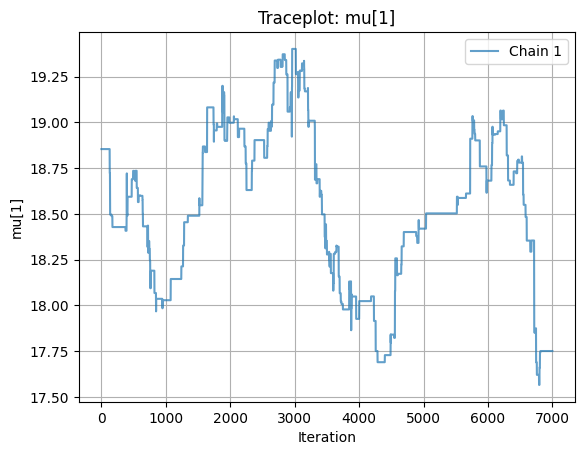

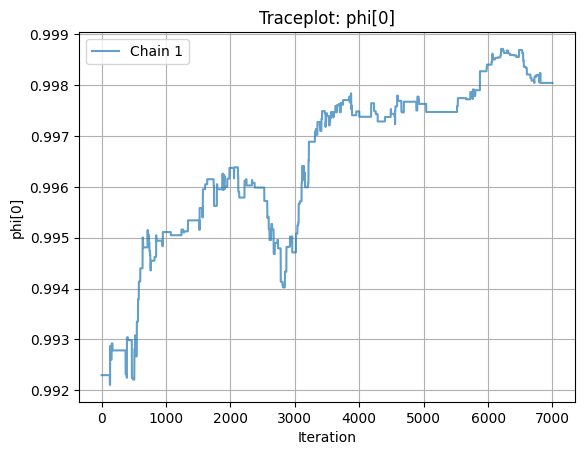

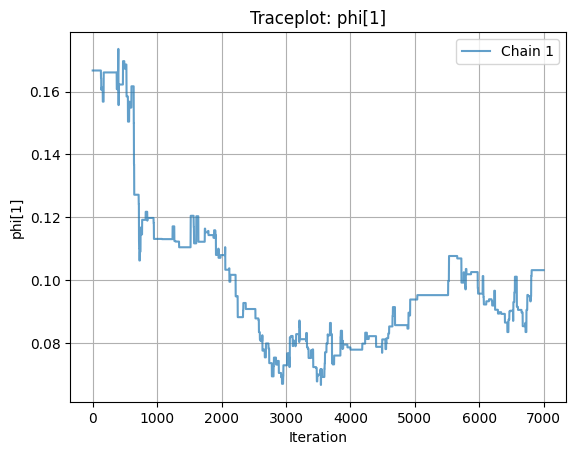

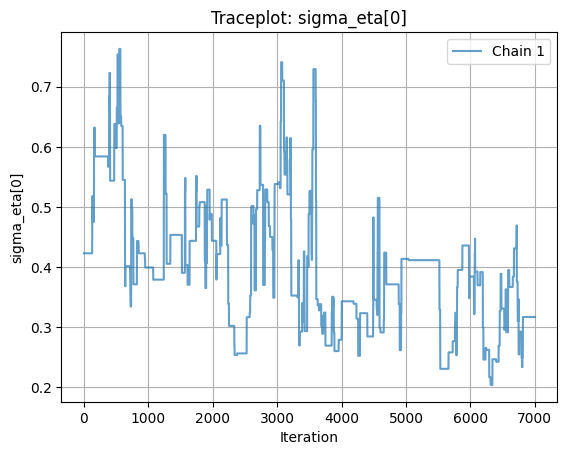

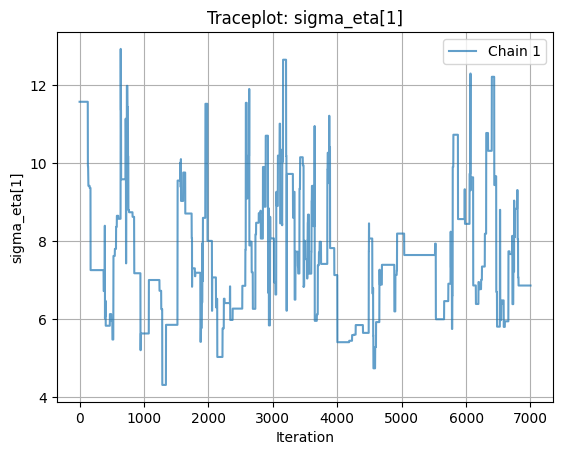

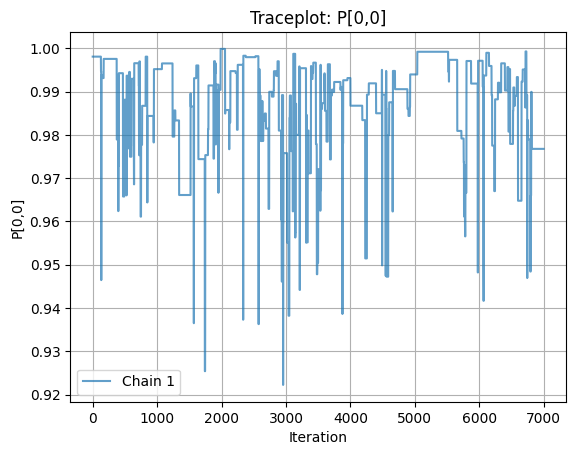

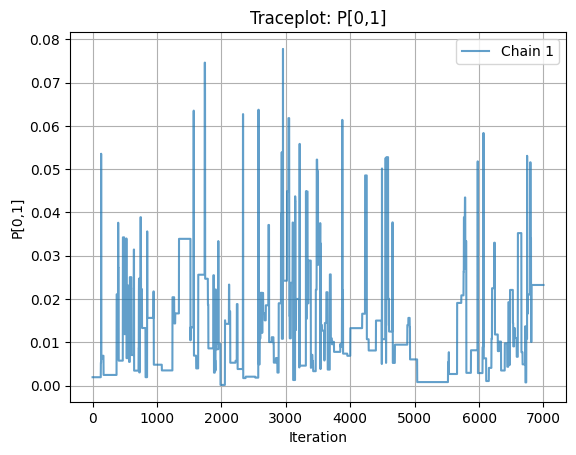

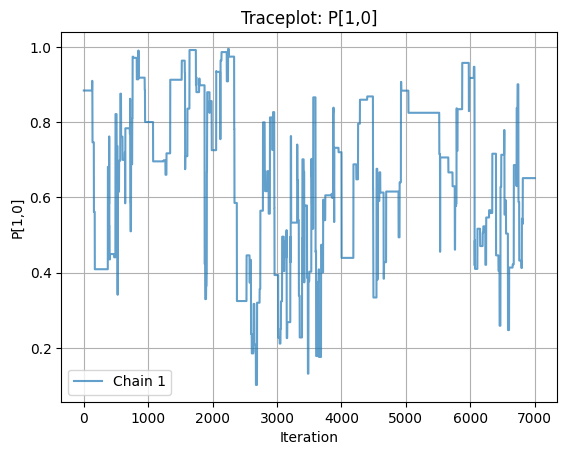

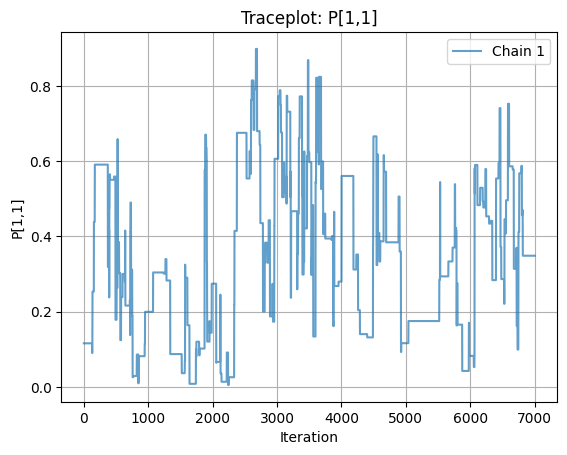

In [18]:
post_samples = []

for chain in range(n_chains):
    _, _, thetas, _ = results_bpf[chain]
    thetas_post = {key: np.array(values[burn_in:]) 
                   for key, values in thetas.items()}
    post_samples.append(thetas_post)

# Get parameter names
param_keys = post_samples[0].keys()

for key in param_keys:

    values = post_samples[0][key]

    # --------------------------------
    # Case 1: scalar parameter (N,)
    # --------------------------------
    if values.ndim == 1:
        plt.figure()
        for chain in range(n_chains):
            plt.plot(post_samples[chain][key],
                     label=f"Chain {chain+1}", alpha=0.7)
        plt.title(f'Traceplot: {key}')
        plt.xlabel('Iteration')
        plt.ylabel(key)
        plt.legend()
        plt.grid()
        plt.show()

    # --------------------------------
    # Case 2: vector parameter (N, K)
    # --------------------------------
    elif values.ndim == 2:
        N, K = values.shape
        for k in range(K):
            plt.figure()
            for chain in range(n_chains):
                plt.plot(post_samples[chain][key][:, k],
                         label=f"Chain {chain+1}", alpha=0.7)
            plt.title(f'Traceplot: {key}[{k}]')
            plt.xlabel('Iteration')
            plt.ylabel(f'{key}[{k}]')
            plt.legend()
            plt.grid()
            plt.show()

    # --------------------------------------
    # Case 3: matrix parameter (N, K, K)
    # --------------------------------------
    elif values.ndim == 3:
        N, K, K2 = values.shape
        for i in range(K):
            for j in range(K2):
                plt.figure()
                for chain in range(n_chains):
                    plt.plot(post_samples[chain][key][:, i, j],
                             label=f"Chain {chain+1}", alpha=0.7)
                plt.title(f'Traceplot: {key}[{i},{j}]')
                plt.xlabel('Iteration')
                plt.ylabel(f'{key}[{i},{j}]')
                plt.legend()
                plt.grid()
                plt.show()